Section A — Setup & imports

In [15]:

# Install Drain3 (template miner) and import libs
!pip install -q drain3

import re, os, json, glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)

# Drain3 imports
from drain3 import TemplateMiner
from drain3.file_persistence import FilePersistence
from drain3.template_miner_config import TemplateMinerConfig

print("Libraries loaded.")


Libraries loaded.


Quick peek at the raw log

In [16]:
# Robust "quick peek" and pattern discovery for /content/HDFS_2k.log
import os, itertools, re
raw_path = "/content/HDFS_2k.log"

if not os.path.exists(raw_path):
    raise FileNotFoundError(f"Log file not found at {raw_path} - recheck upload path")

# Config
N = 200                 # number of lines to read
SHOW = 40               # how many lines to show in the notebook
TRUNC = 200             # truncate printed lines to this many chars

# Read safely up to N lines
sample_lines = []
with open(raw_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in itertools.islice(f, N):
        sample_lines.append(line.rstrip("\n"))

print(f"Read {len(sample_lines)} line(s) from {raw_path} (requested {N}). Showing first {min(SHOW, len(sample_lines))} lines.\n")
for i, ln in enumerate(sample_lines[:SHOW]):
    disp = ln if len(ln) <= TRUNC else ln[:TRUNC] + " ...[truncated]"
    print(f"{i+1:03d}: {disp}")

# Quick automatic pattern checks to help design parser
blk_re = re.compile(r"(blk_[\-\d]+)", re.IGNORECASE)
ip_re = re.compile(r"(\d{1,3}(?:\.\d{1,3}){3}:\d+)")
level_re = re.compile(r"\b(INFO|WARN|ERROR|DEBUG)\b")
comp_re = re.compile(r"\b([\w\.$<>:-]+):")  # common component followed by colon

counts = {
    "with_blk": 0,
    "with_ip": 0,
    "with_level": 0,
    "with_component_colon": 0,
    "short_lines": 0
}
for ln in sample_lines:
    if blk_re.search(ln):
        counts["with_blk"] += 1
    if ip_re.search(ln):
        counts["with_ip"] += 1
    if level_re.search(ln):
        counts["with_level"] += 1
    if comp_re.search(ln):
        counts["with_component_colon"] += 1
    if len(ln) < 30:
        counts["short_lines"] += 1

print("\nPattern summary (on sampled lines):")
for k, v in counts.items():
    print(f" - {k}: {v} / {len(sample_lines)}")

# Show 5 sample lines that contain blk_ (if present) and 5 that do not (to inspect differences)
print("\nUp to 5 lines containing 'blk_':")
blk_lines = [ln for ln in sample_lines if blk_re.search(ln)]
for ln in blk_lines[:5]:
    print("   >", ln[:TRUNC])

print("\nUp to 5 lines NOT containing 'blk_':")
no_blk_lines = [ln for ln in sample_lines if not blk_re.search(ln)]
for ln in no_blk_lines[:5]:
    print("   >", ln[:TRUNC])


Read 200 line(s) from /content/HDFS_2k.log (requested 200). Showing first 40 lines.

001: 081109 203615 148 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_38865049064139660 terminating
002: 081109 203807 222 INFO dfs.DataNode$PacketResponder: PacketResponder 0 for block blk_-6952295868487656571 terminating
003: 081109 204005 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864
004: 081109 204015 308 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_8229193803249955061 terminating
005: 081109 204106 329 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-6670958622368987959 terminating
006: 081109 204132 26 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.43.115:50010 is added to blk_3050920587428079149 size 67108864
007: 081109 204324 34 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updat

# Cell 3 - parsing for /content/HDFS_2k.log

#Template mining with Drain3

In [17]:

import os, re, pandas as pd
from collections import defaultdict

raw_path = "/content/HDFS_2k.log"
assert os.path.exists(raw_path), f"File not found at {raw_path}"

# TUNED REGEX: captures datefrag, timefrag, thread, level, component, and message
# Example line:
# 081109 203615 148 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_38865049064139660 terminating
log_re = re.compile(r"""
    ^\s*
    (?P<datefrag>\d{6})\s+            # e.g., 081109
    (?P<timefrag>\d{6})\s+            # e.g., 203615
    (?P<thread>\d+)\s+                # e.g., 148
    (?P<level>INFO|WARN|ERROR|DEBUG)\s+
    (?P<component>[\w\.$<>:-]+):\s*   # e.g., dfs.DataNode$PacketResponder:
    (?P<message>.*)$                  # rest of the line
""", re.VERBOSE)

# Helper regexes
blk_re = re.compile(r"(blk_[\-\d]+)", re.IGNORECASE)
ip_re = re.compile(r"(?:(?:/)?)(\d{1,3}(?:\.\d{1,3}){3}:\d+)")
# size pattern like 'size 67108864' (optional)
size_re = re.compile(r"\bsize\s+(\d+)\b", re.IGNORECASE)
# src/dest like 'src: /10.251.30.6:33145 dest: /10.251.30.6:50010'
src_re = re.compile(r"src:\s*(?:/)?(\d{1,3}(?:\.\d{1,3}){3}:\d+)", re.IGNORECASE)
dest_re = re.compile(r"dest:\s*(?:/)?(\d{1,3}(?:\.\d{1,3}){3}:\d+)", re.IGNORECASE)

parsed_rows = []
unmatched_lines = []

with open(raw_path, "r", encoding="utf-8", errors="ignore") as fh:
    for i, ln in enumerate(fh):
        ln = ln.rstrip("\n")
        if not ln:
            continue
        m = log_re.match(ln)
        if m:
            gd = m.groupdict()
            message = gd['message']
            blks = blk_re.findall(message)
            ips = ip_re.findall(message)
            size_m = size_re.search(message)
            src_m = src_re.search(message)
            dest_m = dest_re.search(message)
            parsed_rows.append({
                "raw_line": ln,
                "datefrag": gd.get("datefrag"),
                "timefrag": gd.get("timefrag"),
                "thread": gd.get("thread"),
                "level": gd.get("level"),
                "component": gd.get("component"),
                "message": message,
                "block_ids": ",".join(blks) if blks else "",
                "ips": ",".join(ips) if ips else "",
                "size": int(size_m.group(1)) if size_m else None,
                "src_ip": src_m.group(1) if src_m else "",
                "dest_ip": dest_m.group(1) if dest_m else ""
            })
        else:
            # keep unmatched for inspection (do NOT drop silently)
            unmatched_lines.append(ln)

# Build DataFrame and show stats
df_parsed = pd.DataFrame(parsed_rows)
print("Total lines parsed:", len(df_parsed))
print("Total unmatched lines:", len(unmatched_lines))

# Basic column sanity checks
print("\nColumns in parsed dataframe:", df_parsed.columns.tolist())
print("\nSample parsed rows (first 8):")
display(df_parsed.head(8))

# Show counts: unique templates? block_id coverage? levels
print("\nUnique log levels found:", df_parsed['level'].unique().tolist())
print("Number of unique block_ids captured:", df_parsed['block_ids'].replace("", pd.NA).dropna().shape[0])
# count of rows where block_ids non-empty
print("Rows with at least one blk_:", (df_parsed['block_ids']!="").sum(), "/", len(df_parsed))

# Save parsed preview CSV (downloadable)
out_csv = "/content/clean_hdfs_parsed_preview.csv"
df_parsed.to_csv(out_csv, index=False)
print("\nSaved parsed preview to:", out_csv)

# Save a small sample of unmatched lines for inspection
unmatched_sample_path = "/content/unmatched_lines_sample.txt"
with open(unmatched_sample_path, "w", encoding="utf-8", errors="ignore") as uf:
    for ln in unmatched_lines[:200]:
        uf.write(ln + "\n")
print("Saved unmatched sample (first 200) to:", unmatched_sample_path)

# Also show up to 8 unmatched lines here for immediate inspection
if unmatched_lines:
    print("\nUp to 8 unmatched lines (inspect these to see unusual formats):")
    for i, ln in enumerate(unmatched_lines[:8]):
        print(f"UM-{i+1:02d}: {ln[:240]}")
else:
    print("\nNo unmatched lines in the parsed file sample — good.")


Total lines parsed: 2000
Total unmatched lines: 0

Columns in parsed dataframe: ['raw_line', 'datefrag', 'timefrag', 'thread', 'level', 'component', 'message', 'block_ids', 'ips', 'size', 'src_ip', 'dest_ip']

Sample parsed rows (first 8):


,raw_line,datefrag,timefrag,thread,level,component,message,block_ids,ips,size,src_ip,dest_ip
0,081109 203615 148 INFO dfs.DataNode$PacketResp...,081109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...,blk_38865049064139660,,NaN,,
1,081109 203807 222 INFO dfs.DataNode$PacketResp...,081109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...,blk_-6952295868487656571,,NaN,,
2,081109 204005 35 INFO dfs.FSNamesystem: BLOCK*...,081109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,blk_7128370237687728475,10.251.73.220:50010,67108864.0,,
3,081109 204015 308 INFO dfs.DataNode$PacketResp...,081109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...,blk_8229193803249955061,,NaN,,
4,081109 204106 329 INFO dfs.DataNode$PacketResp...,081109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...,blk_-6670958622368987959,,NaN,,
5,081109 204132 26 INFO dfs.FSNamesystem: BLOCK*...,081109,204132,26,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,blk_3050920587428079149,10.251.43.115:50010,67108864.0,,
6,081109 204324 34 INFO dfs.FSNamesystem: BLOCK*...,081109,204324,34,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,blk_7888946331804732825,10.251.203.80:50010,67108864.0,,
7,081109 204453 34 INFO dfs.FSNamesystem: BLOCK*...,081109,204453,34,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,blk_2377150260128098806,10.250.11.85:50010,67108864.0,,



Unique log levels found: ['INFO', 'WARN']
Number of unique block_ids captured: 2000
Rows with at least one blk_: 2000 / 2000

Saved parsed preview to: /content/clean_hdfs_parsed_preview.csv
Saved unmatched sample (first 200) to: /content/unmatched_lines_sample.txt

No unmatched lines in the parsed file sample — good.


In [18]:
# Drain3 template mining (teacher-tuned)
import os, pandas as pd, numpy as np
from drain3 import TemplateMiner
from drain3.file_persistence import FilePersistence
from drain3.template_miner_config import TemplateMinerConfig
import ast

parsed_csv = "/content/clean_hdfs_parsed_preview.csv"
assert os.path.exists(parsed_csv), "Run parsing cell first"

df = pd.read_csv(parsed_csv, low_memory=False)
print("Loaded parsed CSV:", parsed_csv, "shape:", df.shape)

# 1) Clean & convert types
if 'size' in df.columns:
    df['size'] = df['size'].fillna(0).astype(int)

# 2) Ensure timestamp column exists (from previous frag_to_dt if used)
if '_timestamp' not in df.columns:
    # try to create if datefrag/timefrag exist
    def frag_to_dt(row, year=2008):
        try:
            d = str(row.get('datefrag',''))
            t = str(row.get('timefrag',''))
            mm,dd,yy = int(d[0:2]), int(d[2:4]), int(d[4:6])
            yyyy = year
            hh,mi,ss = int(t[0:2]), int(t[2:4]), int(t[4:6])
            return pd.Timestamp(year=yyyy, month=mm, day=dd, hour=hh, minute=mi, second=ss)
        except:
            return pd.NaT
    df['_timestamp'] = df.apply(lambda r: frag_to_dt(r, year=2008), axis=1)

# 3) Normalize block_ids: store as list and primary_trace_id (first element)
def to_list(s):
    if pd.isna(s) or s=="":
        return []
    # if it looks like a python list string, parse
    if isinstance(s, str) and s.startswith('[') and s.endswith(']') and s.strip() != '[]':
        try:
            return ast.literal_eval(s)
        except:
            pass
    return [x.strip() for x in str(s).split(",") if x.strip()]
df['block_id_list'] = df['block_ids'].apply(to_list)
df['trace_id'] = df['block_id_list'].apply(lambda L: L[0] if L else "no_block")

# 4) Split component into module + subcomponent
def split_component(c):
    if pd.isna(c): return ("", "")
    if '$' in c:
        a,b = c.split('$',1)
        return (a, b)
    if '.' in c:
        parts = c.split('.')
        return ('.'.join(parts[:-1]), parts[-1])
    return (c, "")
df[['module','subcomponent']] = df['component'].apply(lambda x: pd.Series(split_component(x)))

# 5) Prepare Drain3
persistence_path = "/content/drain3_persistence"
# Create the directory if it doesn't exist
os.makedirs(persistence_path, exist_ok=True)
# Specify a file path within the directory for persistence
persistence_file = os.path.join(persistence_path, "drain3_state.bin")
persistence = FilePersistence(persistence_file)

config = TemplateMinerConfig()
# TEACHING: adjust these later if templates are too coarse/fine:
# config.max_children = 100
# config.depth = 4
# config.sim_th = 0.5

# Initialize TemplateMiner with the persistence handler
tm = TemplateMiner(config=config, persistence_handler=persistence)

# Load state from persistence if available
if os.path.exists(persistence_file):
    tm.load_state(persistence)

# 6) Run Drain3 on messages (in original file order)
templates = []
template_ids = []
for msg in df['message'].astype(str).tolist():
    tpl = tm.add_log_message(msg)
    # Access template using dictionary key 'template_mined'
    templates.append(tpl['template_mined'])
    # Access event ID using dictionary key 'cluster_id'
    template_ids.append(tpl['cluster_id'])

df['template'] = templates
df['template_id'] = template_ids

# Save state to persistence after processing all messages
tm.save_state(persistence)

# 7) Save results
out1 = "/content/clean_hdfs_with_templates.csv"
out2 = "/content/HDFS_2k.log_templates_mined.csv"
df.to_csv(out1, index=False)
pd.DataFrame({"template_id": df['template_id'], "template": df['template']}).drop_duplicates().to_csv(out2, index=False)

print("Done. Saved parsed+templates to:", out1)
print("Saved unique templates to:", out2)
print("Unique templates count:", df['template'].nunique())
# show top 20 templates
print("\nTop 20 templates by frequency:")
print(df['template'].value_counts().head(20).to_string())

Loaded parsed CSV: /content/clean_hdfs_parsed_preview.csv shape: (2000, 12)
Done. Saved parsed+templates to: /content/clean_hdfs_with_templates.csv
Saved unique templates to: /content/HDFS_2k.log_templates_mined.csv
Unique templates count: 31

Top 20 templates by frequency:
template
PacketResponder <*> for block <*> terminating                                                                                          310
BLOCK* NameSystem.addStoredBlock: blockMap updated: <*> is added to <*> size <*>                                                       300
Receiving block <*> src: <*> dest: <*>                                                                                                 291
Received block <*> of size <*> from <*>                                                                                                280
Deleting block <*> file <*>                                                                                                            262
BLOCK* NameSystem.del

In [19]:
import pandas as pd
from collections import Counter

# Load parsed + templates CSV
df = pd.read_csv("/content/clean_hdfs_with_templates.csv", low_memory=False)

# Sort by timestamp if available (recommended)
if '_timestamp' in df.columns:
    df['_timestamp'] = pd.to_datetime(df['_timestamp'], errors='coerce')
    df = df.sort_values(['trace_id', '_timestamp'])

# ---------- Build Traces ----------
traces = df.groupby('trace_id')['template_id'].apply(list).reset_index()
traces['trace_length'] = traces['template_id'].apply(len)
traces.to_csv("/content/Event_traces.csv", index=False)

print("Traces built. Saved to /content/Event_traces.csv")
print("Number of traces:", len(traces))
print("Trace length stats:")
print(traces['trace_length'].describe())

# ---------- Build Occurrence Matrix ----------
template_ids = sorted(df['template_id'].unique())

rows = []
for tid, group in df.groupby('trace_id'):
    cnt = Counter(group['template_id'])
    row = {'trace_id': tid}
    for t in template_ids:
        row[f"t_{t}"] = cnt.get(t, 0)
    rows.append(row)

occ_df = pd.DataFrame(rows)
occ_df.to_csv("/content/Event_occurrence_matrix.csv", index=False)

print("\nOccurrence matrix saved to /content/Event_occurrence_matrix.csv")
print("Shape of occurrence matrix:", occ_df.shape)


Traces built. Saved to /content/Event_traces.csv
Number of traces: 1994
Trace length stats:
count    1994.000000
mean        1.003009
std         0.054786
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: trace_length, dtype: float64

Occurrence matrix saved to /content/Event_occurrence_matrix.csv
Shape of occurrence matrix: (1994, 18)


In [20]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load occurrence matrix
occ = pd.read_csv("/content/Event_occurrence_matrix.csv")

# Drop trace_id to keep only numeric features
X = occ.drop(columns=["trace_id"])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest (baseline)
iso = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=42
)

iso.fit(X_scaled)

# Predict anomalies
occ["anomaly_score"] = iso.decision_function(X_scaled)
occ["anomaly_label"] = iso.predict(X_scaled)  # -1 = anomaly, 1 = normal

# Save output
occ.to_csv("/content/IF_baseline_results.csv", index=False)

print("Model trained.")
print("Anomaly counts:")
print(occ["anomaly_label"].value_counts())
print("\nSample anomaly scores:")
print(occ[["trace_id","anomaly_score","anomaly_label"]].head())


Model trained.
Anomaly counts:
anomaly_label
 1    1811
-1     183
Name: count, dtype: int64

Sample anomaly scores:
                   trace_id  anomaly_score  anomaly_label
0  blk_-1030832046197982436       0.053831              1
1  blk_-1046472716157313227       0.062347              1
2  blk_-1049340855430710153       0.058686              1
3  blk_-1055254430948037872       0.074188              1
4  blk_-1067234447809438340       0.058686              1


In [21]:
# Setup: imports, seeds, helper functions
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)
RND = 42
np.random.seed(RND)
random.seed(RND)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_recall_fscore_support, classification_report
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

# directories
os.makedirs("/content/plots", exist_ok=True)
os.makedirs("/content/models", exist_ok=True)

print("Setup done.")


Setup done.


In [22]:
# Load occurrence matrix created earlier
occ = pd.read_csv("/content/Event_occurrence_matrix.csv")
print("Occurrence matrix shape:", occ.shape)
trace_ids = occ['trace_id'].astype(str).tolist()
X = occ.drop(columns=['trace_id']).values.astype(float)

# Standardize (important for PCA, clustering, autoencoder)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaled features for reuse
import joblib
joblib.dump(scaler, "/content/models/scaler.joblib")
np.save("/content/models/X_scaled.npy", X_scaled)
print("Saved scaler and scaled features.")


Occurrence matrix shape: (1994, 18)
Saved scaler and scaled features.


PCA explained variance (2 comps): [0.06995724 0.06957326]
k = 2 silhouette = 0.6765
k = 3 silhouette = 0.876
k = 4 silhouette = 0.9236
k = 5 silhouette = 0.9257
k = 6 silhouette = 0.8637
Best k by silhouette: 5


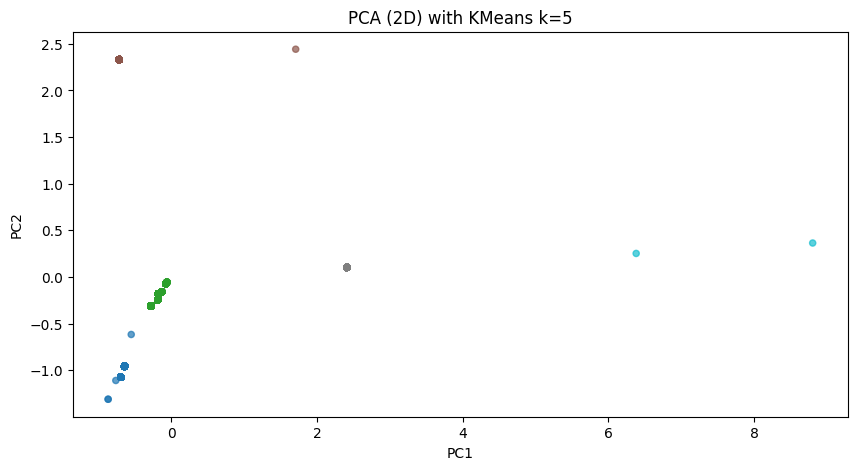

Saved PCA+KMeans results to /content/pca_km_results.csv


In [23]:
# PCA to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=RND)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance (2 comps):", pca.explained_variance_ratio_)

# KMeans cluster (try k = 2..6 and pick best by silhouette)
best_k, best_score, best_labels = None, -1, None
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=RND, n_init=10)
    labels = km.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print("k =", k, "silhouette =", round(score,4))
    if score > best_score:
        best_k, best_score, best_labels = k, score, labels
print("Best k by silhouette:", best_k)

# Fit final KMeans with best_k on PCA space for visualization
km_final = KMeans(n_clusters=best_k, random_state=RND, n_init=20).fit(X_pca)
labels = km_final.labels_

# Visualize PCA clusters
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=20, cmap='tab10', alpha=0.7)
plt.title(f"PCA (2D) with KMeans k={best_k}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.savefig("/content/plots/pca_kmeans.png")
plt.show()

# Define a simple 'anomaly score' from distance to cluster center (in PCA space)
import numpy as np
centers = km_final.cluster_centers_
dists = np.linalg.norm(X_pca - centers[labels], axis=1)
# higher distance -> more anomalous
pca_km_scores = (dists - dists.min())/(dists.max() - dists.min())
# Save pca-kmeans results
df_pca_km = pd.DataFrame({'trace_id': trace_ids, 'pca_km_score': pca_km_scores, 'km_label': labels})
df_pca_km.to_csv("/content/pca_km_results.csv", index=False)
print("Saved PCA+KMeans results to /content/pca_km_results.csv")


In [24]:
# Autoencoder with Keras (dense), using scaled occurrence matrix X_scaled
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

tf.random.set_seed(RND)

input_dim = X_scaled.shape[1]
encoding_dim = max(4, input_dim//3)   # small latent dim
print("Input dim:", input_dim, "encoding dim:", encoding_dim)

# Build autoencoder
inp = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(inp)
x = layers.Dense(64, activation='relu')(x)
encoded = layers.Dense(encoding_dim, activation='relu', name='encoded')(x)
x = layers.Dense(64, activation='relu')(encoded)
x = layers.Dense(128, activation='relu')(x)
decoded = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inputs=inp, outputs=decoded)
encoder = models.Model(inputs=inp, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train / validation split
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(X_scaled, test_size=0.15, random_state=RND)

history = autoencoder.fit(X_train, X_train,
                          epochs=60,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_val, X_val),
                          verbose=2)

# Save model
autoencoder.save("/content/models/autoencoder.h5")
encoder.save("/content/models/encoder.h5")
print("Autoencoder trained and saved.")

# Compute reconstruction error -> anomaly score
recon = autoencoder.predict(X_scaled)
mse = np.mean(np.square(recon - X_scaled), axis=1)
ae_scores = (mse - mse.min())/(mse.max()-mse.min())
df_ae = pd.DataFrame({'trace_id': trace_ids, 'ae_mse': mse, 'ae_score': ae_scores})
df_ae.to_csv("/content/ae_results.csv", index=False)
print("Saved AE results to /content/ae_results.csv")


Input dim: 17 encoding dim: 5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Dense)                 │ (None, 5)              │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,782 (85.09 KB)

 Trainable params: 21,782 (85.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
53/53 - 6s - 113ms/step - loss: 0.8472 - val_loss: 1.1342
Epoch 2/60
53/53 - 1s - 10ms/step - loss: 0.6506 - val_loss: 0.9843
Epoch 3/60
53/53 - 1s - 12ms/step - loss: 0.5382 - val_loss: 0.9111
Epoch 4/60
53/53 - 1s - 12ms/step - loss: 0.4808 - val_loss: 0.8702
Epoch 5/60
53/53 - 1s - 10ms/step - loss: 0.4544 - val_loss: 0.8580
Epoch 6/60
53/53 - 1s - 12ms/step - loss: 0.4202 - val_loss: 0.8336
Epoch 7/60
53/53 - 1s - 13ms/step - loss: 0.4014 - val_loss: 0.8291
Epoch 8/60
53/53 - 2s - 32ms/step - loss: 0.3947 - val_loss: 0.8296
Epoch 9/60
53/53 - 1s - 15ms/step - loss: 0.3748 - val_loss: 0.8221
Epoch 10/60
53/53 - 1s - 11ms/step - loss: 0.3360 - val_loss: 0.8140
Epoch 11/60
53/53 - 0s - 8ms/step - loss: 0.3198 - val_loss: 0.8098
Epoch 12/60
53/53 - 1s - 12ms/step - loss: 0.2920 - val_loss: 0.8055
Epoch 13/60
53/53 - 1s - 10ms/step - loss: 0.2926 - val_loss: 0.8169
Epoch 14/60
53/53 - 1s - 12ms/step - loss: 0.2895 - val_loss: 0.8122
Epoch 15/60
53/53 - 1s - 10ms/step - loss: 

Autoencoder trained and saved.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Saved AE results to /content/ae_results.csv


In [25]:
# Tuned IsolationForest
from sklearn.model_selection import ParameterGrid

param_grid = {
    'n_estimators':[100, 300],
    'max_samples':['auto', 0.6],
    'contamination':[0.03, 0.05, 0.08],
    'max_features':[0.8, 1.0],
    'random_state':[RND]
}
best_cfg = None
best_anom_count = None

# We'll score by anomaly count ~ desired ~ 5% or leave as selecting balanced config.
# Here we pick a config that yields ~5% anomalies if possible.
for cfg in ParameterGrid(param_grid):
    clf = IsolationForest(n_estimators=cfg['n_estimators'],
                          max_samples=cfg['max_samples'],
                          contamination=cfg['contamination'],
                          max_features=cfg['max_features'],
                          random_state=cfg['random_state'])
    clf.fit(X_scaled)
    preds = clf.predict(X_scaled)
    cnt_anom = int((preds==-1).sum())
    # keep config with anomaly rate near 5% (or minimal absolute distance to 5%)
    target = int(0.05 * X_scaled.shape[0])
    score = abs(cnt_anom - target)
    if best_cfg is None or score < best_cfg[0]:
        best_cfg = (score, cfg, cnt_anom, preds)
print("Best config (closest to 5% anomalies):", best_cfg[1], "anomaly_count:", best_cfg[2])

# Save tuned IF results
tuned_preds = best_cfg[3]
df_if_tuned = pd.DataFrame({'trace_id': trace_ids, 'if_tuned_label': tuned_preds})
# Also compute IF anomaly score (decision_function)
clf_best = IsolationForest(**best_cfg[1])
clf_best.fit(X_scaled)
df_if_tuned['if_tuned_score'] = -clf_best.decision_function(X_scaled)
df_if_tuned.to_csv("/content/if_tuned_results.csv", index=False)
print("Saved tuned IF results to /content/if_tuned_results.csv")


Best config (closest to 5% anomalies): {'contamination': 0.08, 'max_features': 0.8, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42} anomaly_count: 104
Saved tuned IF results to /content/if_tuned_results.csv


In [26]:
# Load results
df_if_baseline = pd.read_csv("/content/IF_baseline_results.csv")
df_pca_km = pd.read_csv("/content/pca_km_results.csv")
df_ae = pd.read_csv("/content/ae_results.csv")
df_if_tuned = pd.read_csv("/content/if_tuned_results.csv")

# Normalize labels to 0/1: anomaly=1 for counting
df_if_baseline['if_baseline_anom'] = (df_if_baseline['anomaly_label']==-1).astype(int)
df_if_tuned['if_tuned_anom'] = (df_if_tuned['if_tuned_label']==-1).astype(int)

# For pca_km and ae, mark top X% as anomalies (choose 5%)
pct = 0.05
k = max(1, int(pct * len(df_pca_km)))
df_pca_km = df_pca_km.sort_values('pca_km_score', ascending=False)  # higher is more anomalous (we defined)
df_pca_km['pca_km_anom'] = 0
df_pca_km.iloc[:k, df_pca_km.columns.get_loc('pca_km_anom')] = 1

df_ae = df_ae.sort_values('ae_score', ascending=False)
df_ae['ae_anom'] = 0
df_ae.iloc[:k, df_ae.columns.get_loc('ae_anom')] = 1

# Merge everything - ensure 'if_baseline_anom' is included in the merge
merge = df_if_baseline[['trace_id','anomaly_score','anomaly_label', 'if_baseline_anom']].merge(
    df_if_tuned[['trace_id','if_tuned_score','if_tuned_anom']], on='trace_id')
merge = merge.merge(df_pca_km[['trace_id','pca_km_score','pca_km_anom']], on='trace_id')
merge = merge.merge(df_ae[['trace_id','ae_score','ae_anom']], on='trace_id')

# Summary counts
summary = {
    'method':['IF_baseline','IF_tuned','PCA_KMeans_top5%','AutoEncoder_top5%'],
    'anomaly_count':[int((merge['anomaly_label']==-1).sum()),
                     int(merge['if_tuned_anom'].sum()),
                     int(merge['pca_km_anom'].sum()),
                     int(merge['ae_anom'].sum())]
}
summary_df = pd.DataFrame(summary)
print("Summary anomaly counts:")
print(summary_df.to_string(index=False))
summary_df.to_csv("/content/plots/anomaly_summary.csv", index=False)

# Overlap analysis: Jaccard between methods
def jaccard(a,b):
    a_set = set(merge.loc[merge[a]==1,'trace_id'])
    b_set = set(merge.loc[merge[b]==1,'trace_id'])
    if not a_set and not b_set:
        return 0.0
    return len(a_set & b_set)/len(a_set | b_set)

pairs = [
    ('if_baseline_anom','if_tuned_anom'),
    ('if_baseline_anom','pca_km_anom'),
    ('if_baseline_anom','ae_anom'),
    ('if_tuned_anom','pca_km_anom'),
    ('if_tuned_anom','ae_anom'),
    ('pca_km_anom','ae_anom')
]

for a,b in pairs:
    print(a, b, "Jaccard:", round(jaccard(a,b),4))

# Save merged for inspection
merge.to_csv("/content/merged_method_results.csv", index=False)

Summary anomaly counts:
           method  anomaly_count
      IF_baseline            183
         IF_tuned            104
 PCA_KMeans_top5%             99
AutoEncoder_top5%             99
if_baseline_anom if_tuned_anom Jaccard: 0.5683
if_baseline_anom pca_km_anom Jaccard: 0.4611
if_baseline_anom ae_anom Jaccard: 0.4611
if_tuned_anom pca_km_anom Jaccard: 0.7807
if_tuned_anom ae_anom Jaccard: 0.1341
pca_km_anom ae_anom Jaccard: 0.2


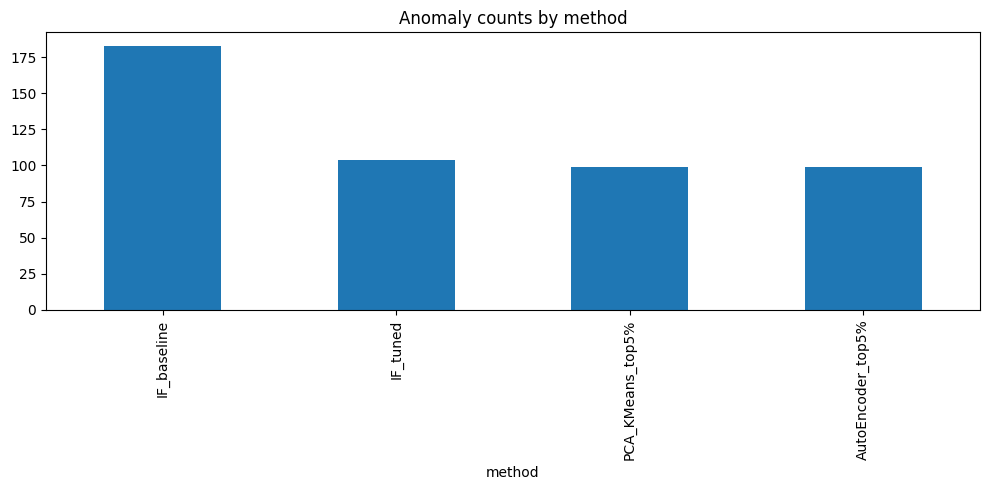

Top 10 by IF baseline (lowest decision function -> most anomalous):
                trace_id  anomaly_score
 blk_6400082566804273401      -0.057230
 blk_8596624696139957935      -0.057230
blk_-7029628814943626474      -0.053212
blk_-1383276859207001328      -0.052623
blk_-1547954353065580372      -0.052623
blk_-2827716238972737794      -0.052623
blk_-4117999745005013424      -0.052623
blk_-4980916519894289629      -0.052623
blk_-4984504651603069357      -0.052623
blk_-6160667975382232149      -0.052623

Top 10 by AE (highest ae_score):
                trace_id  ae_score
 blk_4029139044660806713  1.000000
blk_-8570780307468499817  0.959341
blk_-9016567407076718172  0.651189
blk_-4411589101766563890  0.134413
 blk_1473949624670719319  0.133357
 blk_4292382298896622412  0.046168
blk_-7571492020523929240  0.039792
blk_-5140072410813878235  0.013617
 blk_8048594464172649365  0.013617
 blk_8596624696139957935  0.003443

Top 10 by PCA-KMeans (largest pca_km_score):
                trace_id  p

In [27]:
# Top anomalies intersection Venn-like quick checks (bar chart sizes)
summary_df.plot(kind='bar', x='method', y='anomaly_count', legend=False)
plt.title("Anomaly counts by method")
plt.tight_layout()
plt.savefig("/content/plots/anomaly_counts_by_method.png")
plt.show()

# Show top 10 traces by each method
print("Top 10 by IF baseline (lowest decision function -> most anomalous):")
print(df_if_baseline.nsmallest(10,'anomaly_score')[['trace_id','anomaly_score']].to_string(index=False))

print("\nTop 10 by AE (highest ae_score):")
print(df_ae.nlargest(10,'ae_score')[['trace_id','ae_score']].to_string(index=False))

print("\nTop 10 by PCA-KMeans (largest pca_km_score):")
print(df_pca_km.nlargest(10,'pca_km_score')[['trace_id','pca_km_score']].to_string(index=False))


In [28]:
# Full pipeline: detect_anomalies(log_file_path)
# Copy -> paste -> run in Colab (after previous cells)
!pip install -q drain3
import os, re, ast, joblib, pandas as pd, numpy as np
from collections import Counter, defaultdict
from drain3 import TemplateMiner
from drain3.file_persistence import FilePersistence
from drain3.template_miner_config import TemplateMinerConfig
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# ---------- Configuration: paths & hyperparams ----------
DRAIN3_PERSISTENCE = "/content/drain3_persistence"           # existing Drain3 state (if present)
DRAIN3_PERSISTENCE_NORM = "/content/drain3_persistence_norm" # normalized Drain3 state (if available)
HIST_OCC_MATRIX = "/content/Event_occurrence_matrix.csv"     # historical occurrence matrix (used to train model)
SAVED_SCALER = "/content/models/scaler.joblib"
SAVED_IF = "/content/models/if_tuned.joblib"
DEFAULT_IF_CFG = {
    "n_estimators": 300,
    "max_samples": 0.6,
    "contamination": 0.05,
    "max_features": 0.8,
    "random_state": 42
}
os.makedirs("/content/models", exist_ok=True)

# ---------- Helper regexes and functions ----------
log_re = re.compile(r"""
    ^\s*
    (?P<datefrag>\d{6})\s+
    (?P<timefrag>\d{6})\s+
    (?P<thread>\d+)\s+
    (?P<level>INFO|WARN|ERROR|DEBUG)\s+
    (?P<component>[\w\.$<>:-]+):\s*
    (?P<message>.*)$
""", re.VERBOSE)

blk_re = re.compile(r"blk_[\-\d]+", re.IGNORECASE)
ip_re = re.compile(r"(?:(?:/)?)([\d]{1,3}(?:\.[\d]{1,3}){3}:\d+)")
size_re = re.compile(r"\bsize\s+\d+\b", re.IGNORECASE)
long_int_re = re.compile(r"\b\d{6,}\b")

def normalize_message(msg: str):
    """Replace variable tokens with placeholders for consistent templates."""
    if not isinstance(msg, str):
        msg = str(msg)
    s = msg
    s = blk_re.sub("blk_<*>", s)
    s = ip_re.sub("<IP:PORT>", s)
    s = size_re.sub("size <*>", s)
    s = long_int_re.sub("<NUM>", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_log_file_to_df(log_path: str, max_lines=None):
    """Parse raw log file into DataFrame with extracted columns."""
    rows = []
    with open(log_path, "r", encoding="utf-8", errors="ignore") as fh:
        for i, ln in enumerate(fh):
            if max_lines and i>=max_lines: # Use `max_lines` as an upper bound for reading. `f` has no `seek`. So this is the correct way.
                break
            ln = ln.rstrip("\n")
            if not ln:
                continue
            m = log_re.match(ln)
            if m:
                gd = m.groupdict()
                msg = gd['message']
                rows.append({
                    "raw_line": ln,
                    "datefrag": gd.get("datefrag"),
                    "timefrag": gd.get("timefrag"),
                    "thread": gd.get("thread"),
                    "level": gd.get("level"),
                    "component": gd.get("component"),
                    "message": msg,
                    "block_ids": ",".join(blk_re.findall(msg)) if blk_re.search(msg) else "",
                    "ips": ",".join(ip_re.findall(msg)) if ip_re.search(msg) else ""
                })
            else:
                # fallback: keep raw as message if parsing fails
                rows.append({
                    "raw_line": ln,
                    "datefrag": None,
                    "timefrag": None,
                    "thread": None,
                    "level": None,
                    "component": None,
                    "message": ln,
                    "block_ids": ",".join(blk_re.findall(ln)) if blk_re.search(ln) else "",
                    "ips": ",".join(ip_re.findall(ln)) if ip_re.search(ln) else ""
                })
    df = pd.DataFrame(rows)
    # Normalize block id list and trace id (use first blk as trace)
    def to_list(s):
        if pd.isna(s) or s=="":
            return []
        if isinstance(s, str) and s.startswith('[') and s.endswith(']') and s.strip() != '[]':
            try:
                return ast.literal_eval(s)
            except:
                pass
        return [x.strip() for x in str(s).split(",") if x.strip()]
    df['block_id_list'] = df['block_ids'].apply(to_list)
    df['trace_id'] = df['block_id_list'].apply(lambda L: L[0] if L else "no_block")
    # compute approximate timestamp if datefrag/timefrag present (assume 2008)
    def frag_to_dt(row, year=2008):
        try:
            d = str(row.get('datefrag',''))
            t = str(row.get('timefrag',''))
            if len(d)>=6 and len(t)>=6:
                mm,dd,yy = int(d[0:2]), int(d[2:4]), int(d[4:6])
                hh,mi,ss = int(t[0:2]), int(t[2:4]), int(t[4:6])
                return pd.Timestamp(year=year, month=mm, day=dd, hour=hh, minute=mi, second=ss)
        except:
            pass
        return pd.NaT
    df['_timestamp'] = df.apply(lambda r: frag_to_dt(r, year=2008), axis=1)
    return df

# ---------- Train or load the Tuned IsolationForest ----------
def get_or_train_if_model(occ_csv_path=HIST_OCC_MATRIX, scaler_path=SAVED_SCALER, if_path=SAVED_IF, if_cfg=DEFAULT_IF_CFG):
    """
    Load existing model+scaler if present, otherwise train a new tuned IF on historical occurrence matrix.
    Returns: (clf, scaler, template_id_cols)
    """
    # If both saved model and scaler exist, load them
    if os.path.exists(if_path) and os.path.exists(scaler_path):
        try:
            clf = joblib.load(if_path)
            scaler = joblib.load(scaler_path)
            # get template columns from historical file if available
            if os.path.exists(occ_csv_path):
                occ = pd.read_csv(occ_csv_path, low_memory=False)
                tmpl_cols = [c for c in occ.columns if c.startswith("t_")]
            else:
                tmpl_cols = None
            print("Loaded existing IF model and scaler.")
            return clf, scaler, tmpl_cols
        except Exception as e:
            print("Failed to load existing IF/scaler:", e)
            # fall through to training
    # Otherwise train using historical occ matrix if available
    if os.path.exists(occ_csv_path):
        occ = pd.read_csv(occ_csv_path, low_memory=False)
        tmpl_cols = [c for c in occ.columns if c.startswith("t_")]
        if not tmpl_cols:
            raise RuntimeError("Historical occurrence matrix has no t_ columns.")
        X_hist = occ[tmpl_cols].values.astype(float)
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X_hist)
        clf = IsolationForest(**if_cfg)
        clf.fit(Xs)
        # Save for future use
        joblib.dump(clf, if_path)
        joblib.dump(scaler, scaler_path)
        print(f"Trained new IF on historical data and saved to {if_path} and {scaler_path}")
        return clf, scaler, tmpl_cols
    else:
        # No historical data: will train model on current occurrence matrix later (caller should handle)
        print("No historical occurrence matrix found; caller must provide training data or accept on-the-fly training.")
        return None, None, None

# ---------- Main detect_anomalies function ----------
def detect_anomalies(log_file_path: str,
                     use_normalize=True,
                     drain3_persistence_path_candidates=None,
                     train_if_if_no_hist=True,
                     return_top_n=30,
                     save_results=True):
    """
    End-to-end anomaly detection for a single log file.
    - Parses file, normalizes messages, applies existing Drain3 templates (or new Drain3 if not present)
    - Builds traces and occurrence matrix for that file's traces
    - Loads or trains a tuned IsolationForest based on historical matrix if present
    - Scores current traces and returns a DataFrame with trace_id, score, label, and raw_lines_sample
    """
    if drain3_persistence_path_candidates is None:
        drain3_persistence_path_candidates = [DRAIN3_PERSISTENCE_NORM, DRAIN3_PERSISTENCE, "/content/drain3_persistence"]
    # 1) Parse file
    assert os.path.exists(log_file_path), f"Log file not found: {log_file_path}"
    df = parse_log_file_to_df(log_file_path)
    if df.empty:
        raise RuntimeError("Parsed DataFrame is empty.")
    # 2) Normalize messages (and preserve original)
    df['message_norm'] = df['message'].astype(str).apply(normalize_message) if use_normalize else df['message'].astype(str)
    # 3) Setup Drain3 (prefer normalized persistence path)
    chosen_persistence_dir = None
    for p in drain3_persistence_path_candidates:
        if os.path.exists(p) and os.path.isdir(p): # Check if it's an existing directory
            chosen_persistence_dir = p
            break
    if chosen_persistence_dir is None:
        # create persistence directory at DRAIN3_PERSISTENCE_NORM
        chosen_persistence_dir = DRAIN3_PERSISTENCE_NORM
        os.makedirs(chosen_persistence_dir, exist_ok=True)
        print("No existing Drain3 persistence directory found; created new at", chosen_persistence_dir)

    # Specify a file path within the directory for persistence
    persistence_file_path = os.path.join(chosen_persistence_dir, "drain3_state.bin")
    persistence = FilePersistence(persistence_file_path)
    config = TemplateMinerConfig()
    tm = TemplateMiner(config=config, persistence_handler=persistence)
    # 4) Mine/add templates for the messages in this file (this will reuse persisted clusters if present)
    templates = []
    template_ids = []
    for msg in df['message_norm'].astype(str).tolist():
        tpl = tm.add_log_message(msg)
        # Access template and cluster ID using dictionary keys, as tpl is a dict
        templates.append(tpl['template_mined'])
        template_ids.append(tpl['cluster_id'])
    df['template'] = templates
    df['template_id'] = template_ids
    # Save/flush drain state
    tm.save_state(persistence)

    # 5) Build traces: group by trace_id and list template_ids
    # Use timestamp ordering if available
    if '_timestamp' in df.columns and df['_timestamp'].notna().sum()>0:
        df['_timestamp'] = pd.to_datetime(df['_timestamp'], errors='coerce')
        df = df.sort_values(['trace_id','_timestamp'])
    traces = df.groupby('trace_id')['template_id'].apply(list).reset_index().rename(columns={'template_id':'template_sequence'})
    traces['trace_length'] = traces['template_sequence'].apply(len)

    # 6) Build occurrence matrix for these traces
    unique_tpls = sorted(df['template_id'].unique())
    rows = []
    trace_to_raw = {}  # collect sample raw lines per trace for post-mortem
    for tid, group in df.groupby('trace_id'):
        cnt = Counter(group['template_id'].tolist())
        row = {'trace_id': tid}
        for t in unique_tpls:
            row[f"t_{t}"] = cnt.get(t, 0)
        rows.append(row)
        # keep up to 8 raw lines per trace for inspection
        trace_to_raw[tid] = "\n".join(group['raw_line'].head(8).tolist())
    occ_df_new = pd.DataFrame(rows)
    if occ_df_new.empty:
        raise RuntimeError("Occurrence matrix built is empty.")

    # 7) Get or train IF model (prefer existing HIST_OCC_MATRIX)
    clf, scaler, tmpl_cols_hist = get_or_train_if_model()
    # If model wasn't available, train on historical absence: train on this new occ_df_new
    if clf is None or scaler is None:
        print("Training IF model on current file's occurrence matrix (no historical data detected).")
        X = occ_df_new.drop(columns=['trace_id']).values.astype(float)
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)
        clf = IsolationForest(**DEFAULT_IF_CFG)
        clf.fit(Xs)
        # save for future inference
        joblib.dump(clf, SAVED_IF)
        joblib.dump(scaler, SAVED_SCALER)
        tmpl_cols_hist = occ_df_new.columns.drop('trace_id').tolist()
        print(f"Trained and saved IF model to {SAVED_IF} and scaler to {SAVED_SCALER}")

    # 8) If historical template columns exist and differ from current, align features:
    #    If templ_cols_hist is not None, build a feature vector where missing historical t_* get zeros,
    #    and extra current t_* are ignored (or appended if you prefer retraining).
    hist_cols = tmpl_cols_hist
    cur_cols = [c for c in occ_df_new.columns if c.startswith("t_")]
    if hist_cols is not None:
        # Align: create X_aligned with hist_cols order (missing -> 0)
        X_aligned = []
        for _, row in occ_df_new.iterrows():
            vals = []
            for c in hist_cols:
                vals.append(row[c] if c in row.index else 0)
            X_aligned.append(vals)
        X_aligned = np.array(X_aligned, dtype=float)
        # scale using loaded scaler
        try:
            Xs_new = scaler.transform(X_aligned)
        except Exception as e:
            # if scaler incompatible dimension, fallback to fitting a new scaler on aligned
            print("Scaler transform failed; refitting scaler on aligned features:", e)
            scaler = StandardScaler()
            Xs_new = scaler.fit_transform(X_aligned)
            joblib.dump(scaler, SAVED_SCALER)
    else:
        # No historical columns: scale current features and use
        X = occ_df_new.drop(columns=['trace_id']).values.astype(float)
        Xs_new = scaler.transform(X) if scaler is not None else StandardScaler().fit_transform(X)

    # 9) Score traces with IF
    scores = clf.decision_function(Xs_new)   # higher = more normal
    # convert to anomaly_score where higher = more anomalous (consistent with our other scores)
    anomaly_score = -scores
    labels = clf.predict(Xs_new)  # -1 anomaly, 1 normal

    res_df = pd.DataFrame({
        'trace_id': occ_df_new['trace_id'].tolist(),
        'anomaly_score': anomaly_score,
        'anomaly_label_if': labels
    })
    # map -1 -> 1 as anomaly_flag, 1 -> 0
    res_df['anomaly_flag'] = (res_df['anomaly_label_if'] == -1).astype(int)
    # attach a sample raw_lines for manual inspection
    res_df['raw_sample'] = res_df['trace_id'].apply(lambda t: trace_to_raw.get(t,""))

    # Save results
    if save_results:
        out_path = "/content/detect_anomalies_results.csv"
        # merge with traces length
        res_df = res_df.merge(traces[['trace_id','trace_length']], on='trace_id', how='left')
        res_df.to_csv(out_path, index=False)
        print("Saved detection results to:", out_path)

    # Return top N most anomalous traces (by anomaly_score desc)
    top = res_df.sort_values('anomaly_score', ascending=False).head(return_top_n).reset_index(drop=True)
    print(f"Detected {int(res_df['anomaly_flag'].sum())} anomalous traces out of {len(res_df)} (flagged by IF).")
    return {'all_results': res_df, 'top_results': top, 'occurrence_matrix': occ_df_new, 'traces': traces}

# ---------- End of pipeline code ----------
print("Pipeline code loaded. Use detect_anomalies('/path/to/log') to run.")

Pipeline code loaded. Use detect_anomalies('/path/to/log') to run.


In [29]:
out = detect_anomalies("/content/HDFS_2k.log")
top = out['top_results']
top.head(20)


Loaded existing IF model and scaler.


ValueError: X has 17 features, but IsolationForest is expecting 16 features as input.